In [50]:
# Imports
import random
import pandas as pd
import numpy as np

# DAAT Imports
import daat
from daat import Instruction as daat_ins
from daat import daat_test

# TQDM
from tqdm.auto import tqdm, trange

# sklearn
import sklearn.svm as skl_svm
import sklearn.preprocessing as skl_prep

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

import tensorflow as tf

# Test 1: NASA KC1 Dataset

In [2]:
# globale Einstellungen
path_ds_nasa = "./data/kc1.csv"
ds_kc1 = pd.read_csv(path_ds_nasa)

In [3]:
# Analyser
an_nasa = daat.Analyser(ds_kc1)
an_nasa.drop_line([0,1])
an_nasa.transform_feature('defects')
an_nasa.show_dataset_info()

processing features:   0%|          | 0/22 [00:00<?, ?it/s]

Datensatz Übersicht
Feature Anzahl:          22
Anazhl Einträge:       2107
leere Einträge:           0
----------------------------------------------------------------------------------------------------------------
kleinstes Feature : defects    | Anzahl 2          | ML Art: Klassifikation
größtes Feature   : e          | Anzahl 960        | ML Art: Regression

Feature Übersicht
----------------------------------------------------------------------------------------------------------------
Feature              | Type       | Gesamt     | Einzel     | NaNs       || min        | 50%        | max        
----------------------------------------------------------------------------------------------------------------
loc                  | float64    |       2107 |        138 |          0 ||       1.00 |       9.00 |     288.00 
v(g)                 | float64    |       2107 |         30 |          0 ||       1.00 |       1.00 |      45.00 
ev(g)                | float64    |       2107 |

complete:    2107 
train data:  1474   0.70 
test data:    633   0.30 
gen data:     632   0.30 


processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

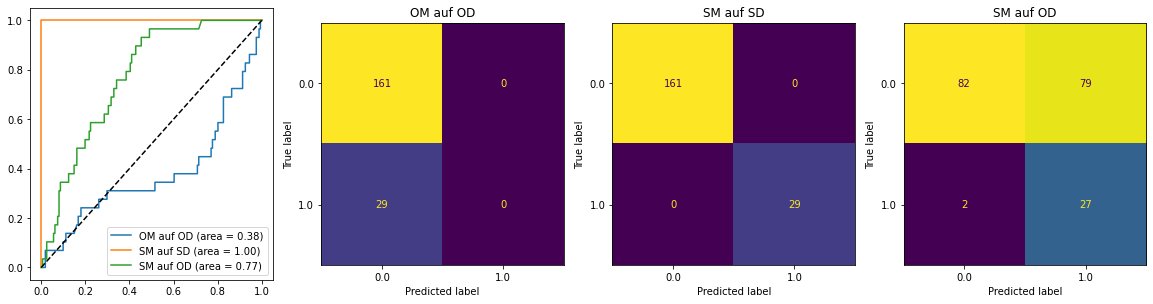

Auswertung Setup mit linearer SVC
Modell          | Accuracy   | Precision  | Recall     | F1        
OM auf OD       | 0.85       | 0.00       | 0.00       | 0.00      
SM auf SD       | 1.00       | 1.00       | 1.00       | 1.00      
SM auf OD       | 0.57       | 0.25       | 0.93       | 0.40      


0

In [4]:
ds_nasa_an = an_nasa.dataset
_, _ ,ds_nasa_gen = daat_test.split_data_from_all(ds_nasa_an, 'defects', 0.7, 0.3)

# Datensatz Augmentation Einstellung
aug_kc1 = daat.Generator(ds_nasa_gen, 'defects')

# Unabhängige Werte über Distribution
aug_kc1.add_instruction(daat_ins('total_Op', daat.Gen_Distribution(rng_min=0)))
aug_kc1.add_instruction(daat_ins('total_Opnd', daat.Gen_Distribution(rng_min=0)))

# uniq sollten jeweils kleiner sein als total -> total beachten
aug_kc1.add_instruction(daat_ins('uniq_Op', daat.Gen_NextMean(10), ['total_Op']))
aug_kc1.add_instruction(daat_ins('uniq_Opnd', daat.Gen_NextMean(10), ['total_Opnd']))

aug_kc1.add_instruction(daat_ins('lOCode', daat.Gen_NextMean(10, rng_min=0)))
aug_kc1.add_instruction(daat_ins('lOComment', daat.Gen_Cluster(10, rng_min=0)))
aug_kc1.add_instruction(daat_ins('lOBlank', daat.Gen_Cluster(10, rng_min=0)))
aug_kc1.add_instruction(daat_ins('locCodeAndComment', daat.Gen_None()))

# Alle berechneten Werte mit Spline
aug_kc1.add_instruction(daat_ins('n', daat.Gen_Spline(), ['total_Op', 'total_Opnd']))
aug_kc1.add_instruction(daat_ins('v', daat.Gen_Spline(), 'n'))
aug_kc1.add_instruction(daat_ins('l', daat.Gen_Spline(), ['uniq_Opnd', 'n'])) # berechnet mit v' (aus uniq_Opnd)
aug_kc1.add_instruction(daat_ins('d', daat.Gen_NextMean(5), 'l'))
aug_kc1.add_instruction(daat_ins('i', daat.Gen_NextMean(5), ['uniq_Opnd', 'd'])) # berechnet mit 1/l' (l' = 1/d)
aug_kc1.add_instruction(daat_ins('e', daat.Gen_Spline(), ['v', 'l'])) # berechnet mit l' und v'
aug_kc1.add_instruction(daat_ins('t', daat.Gen_Spline(), 'e'))
aug_kc1.add_instruction(daat_ins('b', daat.Gen_Spline(), ['n', 'v']))

aug_kc1.add_instruction(daat_ins('loc', daat.Gen_Recombine(5, rng_min=0), 'lOCode'))
aug_kc1.add_instruction(daat_ins('branchCount', daat.Gen_Recombine(15,rng_min=0), ['lOCode', 'lOComment', 'lOBlank', 'locCodeAndComment']))
aug_kc1.add_instruction(daat_ins('v(g)', daat.Gen_Spline(), 'branchCount'))
aug_kc1.add_instruction(daat_ins('ev(g)', daat.Gen_Spline(), 'branchCount'))
aug_kc1.add_instruction(daat_ins('iv(g)', daat.Gen_Spline(), 'branchCount'))

# aug_kc1.status()
aug_kc1.verify_setup()#balance=True)

In [5]:
aug_kc1.generate_syn_data(n_samples=len(ds_nasa_an), equal=True)
ds_aug_kc1 = aug_kc1.get_syn_data()

an_syn = daat.Analyser(ds_aug_kc1)
an_syn.show_dataset_info()

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing features:   0%|          | 0/22 [00:00<?, ?it/s]

Datensatz Übersicht
Feature Anzahl:          22
Anazhl Einträge:       2108
leere Einträge:           0
----------------------------------------------------------------------------------------------------------------
kleinstes Feature : locCodeAndComment | Anzahl 1          | ML Art: Klassifikation
größtes Feature   : i          | Anzahl 307        | ML Art: Regression

Feature Übersicht
----------------------------------------------------------------------------------------------------------------
Feature              | Type       | Gesamt     | Einzel     | NaNs       || min        | 50%        | max        
----------------------------------------------------------------------------------------------------------------
loc                  | float64    |       2108 |         77 |          0 ||       1.00 |      23.00 |     179.00 
v(g)                 | float64    |       2108 |         18 |          0 ||       1.00 |       3.00 |      27.00 
ev(g)                | float64    |      

plotting data:   0%|          | 0/22 [00:00<?, ?it/s]

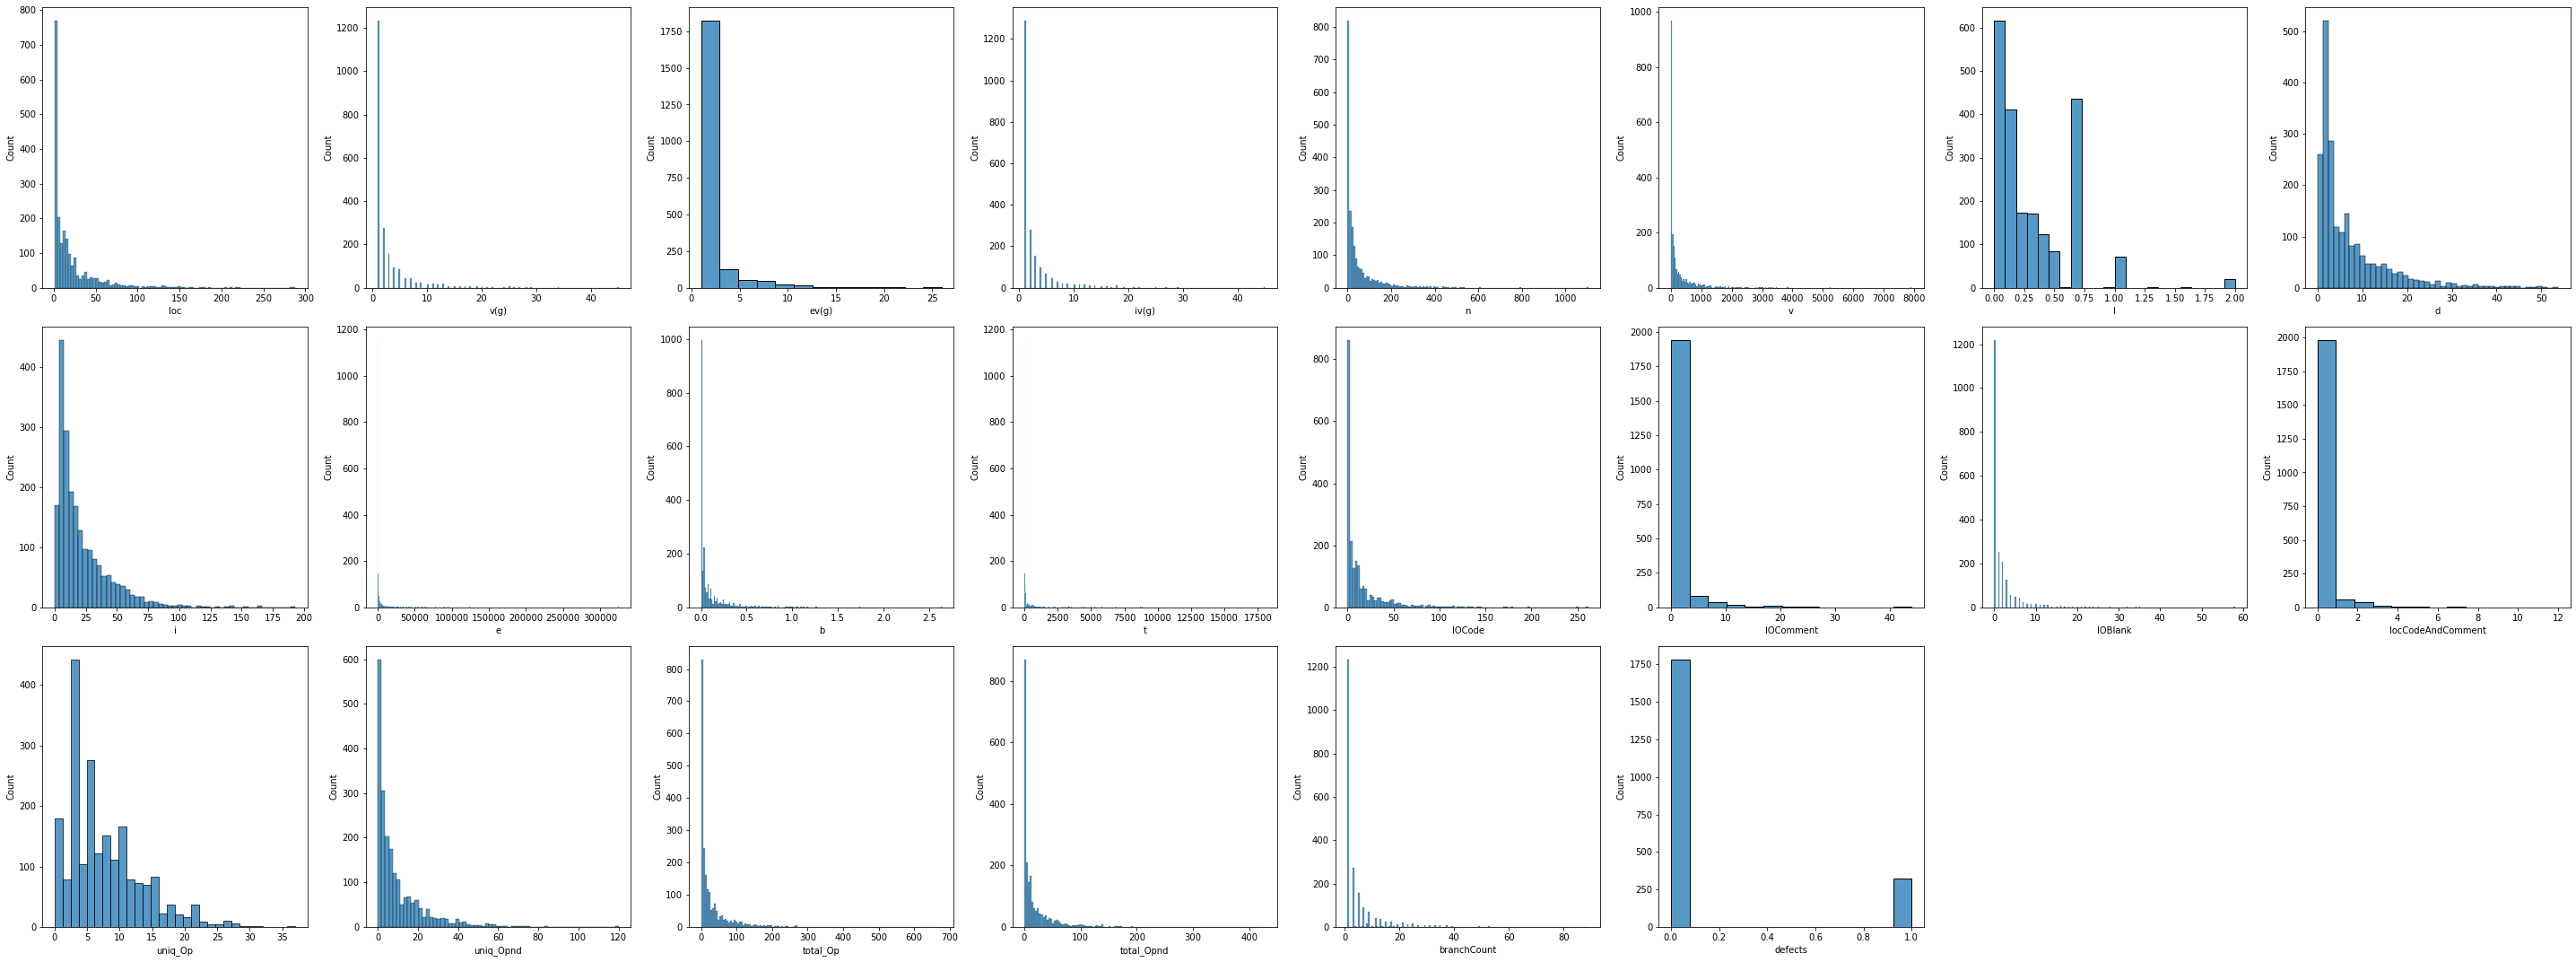

plotting data:   0%|          | 0/22 [00:00<?, ?it/s]

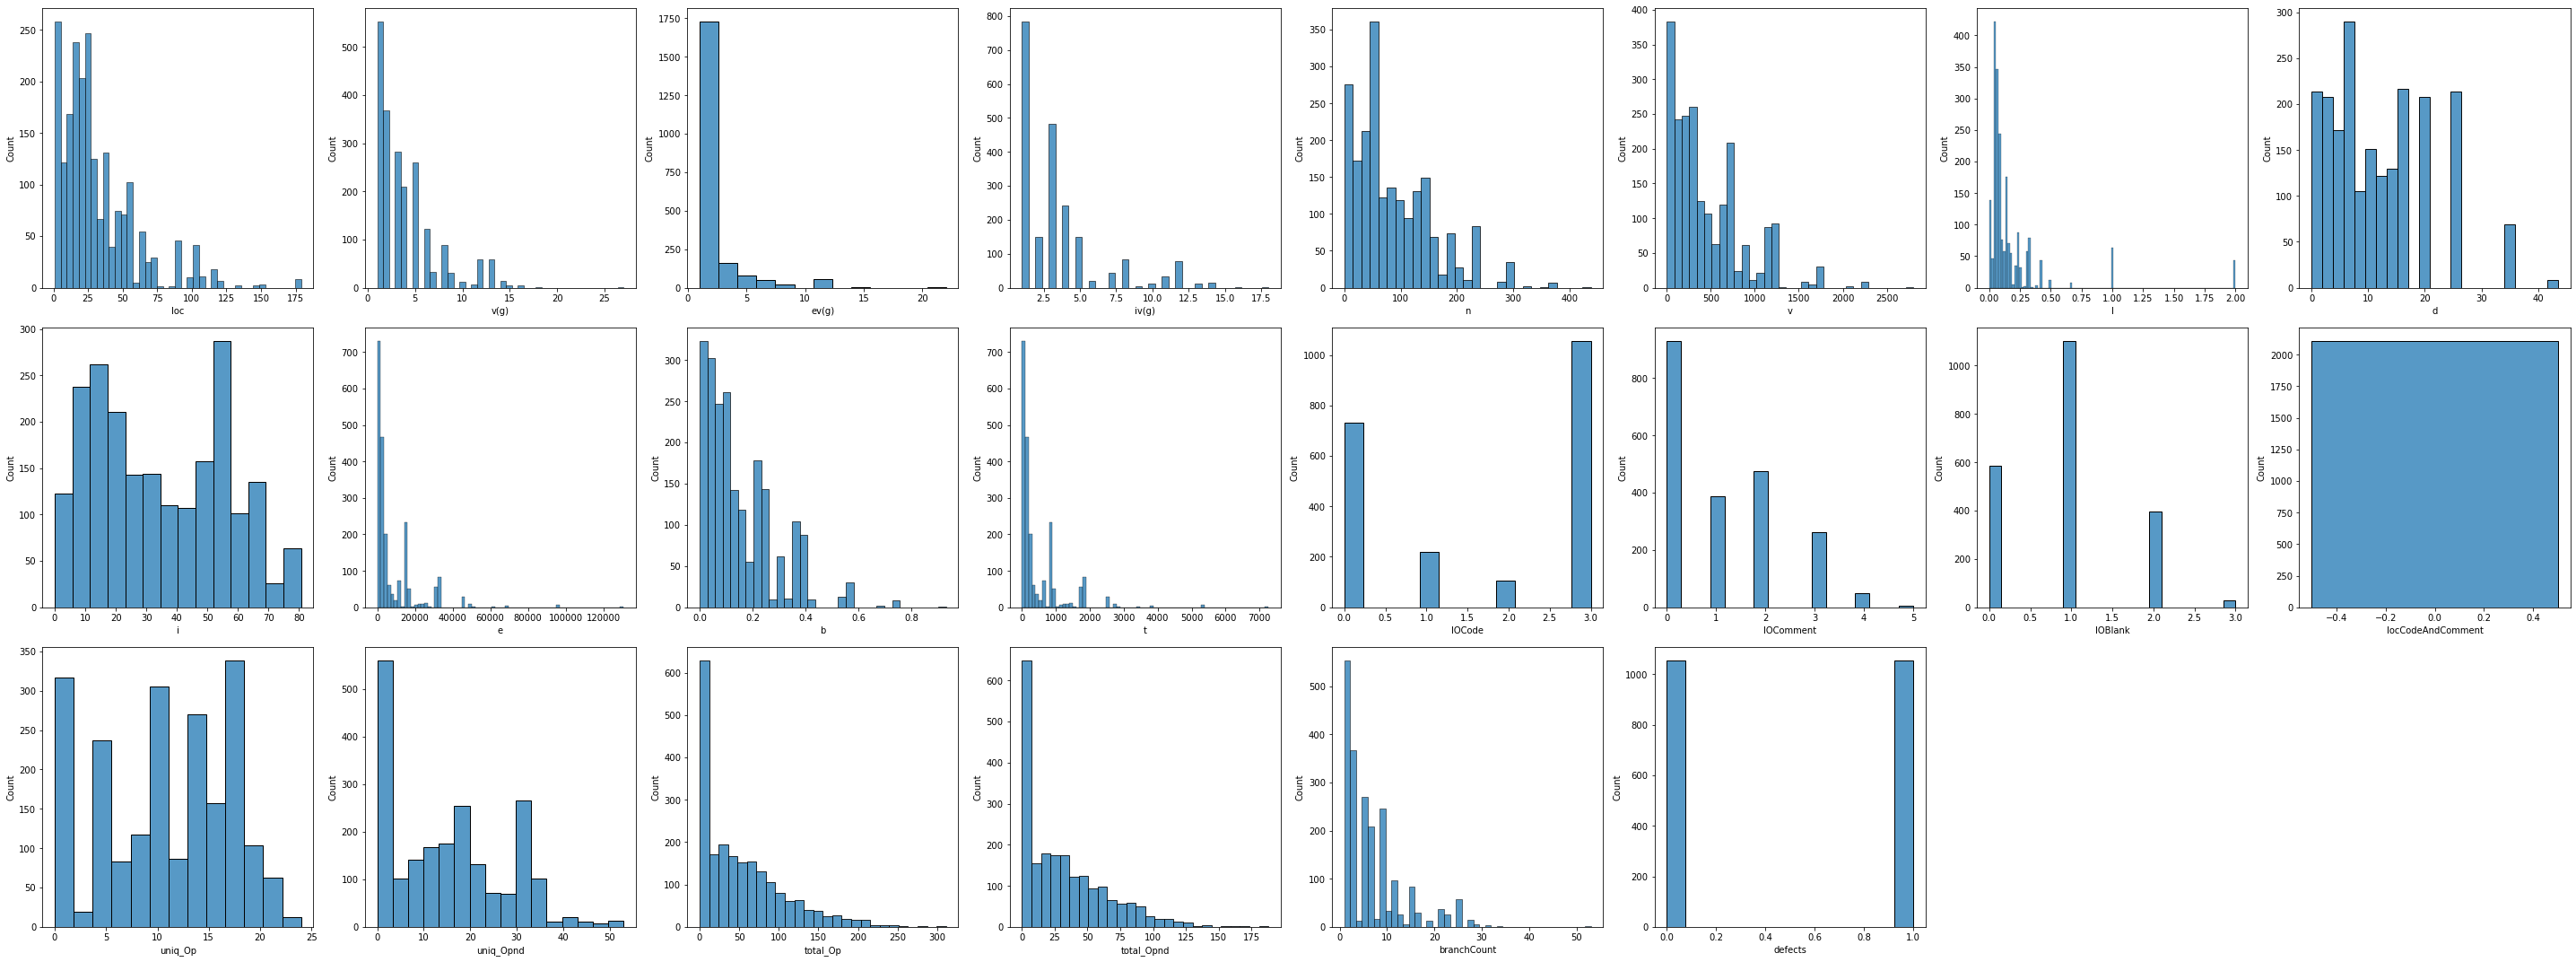

In [6]:
f_name = 'branchCount'

an_nasa.plot_features(inline = 8, color=True)
an_syn.plot_features(inline = 8, color=True)

In [7]:
tester = daat.Verification(ds_nasa_an, ds_aug_kc1)
tester.eval_class_data_set('defects', 0.7, weights='balanced')

fitting SVMs:   0%|          | 0/4 [00:00<?, ?it/s]

Data Set Evaluation
--------------------------------------------------------------------------------------------------------------------------
| Modell     ||         OG 70           ||         Syn 70          ||         OG 100          ||         Syn 100         |
| Metric     ||   OG 30    |   Syn 30   ||   OG 30    |   Syn 30   ||   OG 100   |   Syn 100  ||   OG 100   |   Syn 100  |
--------------------------------------------------------------------------------------------------------------------------
| Accuracy   ||      0.744 |      0.637 ||      0.581 |      1.000 ||      0.737 |      0.648 ||      0.547 |      1.000 |
| Precision  ||      0.352 |      0.582 ||      0.265 |      1.000 ||      0.344 |      0.593 ||      0.247 |      1.000 |
| Recall     ||      0.776 |      0.965 ||      0.959 |      1.000 ||      0.778 |      0.948 ||      0.942 |      1.000 |
| F1         ||      0.484 |      0.726 ||      0.415 |      1.000 ||      0.477 |      0.729 ||      0.391 |      1.00

In [8]:
# Datensatz Einstellungen
PATH_DATASET_KC1 = "./data/kc1.csv"

KC1_COLUMNS = ['loc', 'v(g)', 'ev(g)', 'iv(g)', 'n', 'v', 'l', 'd', 'i', 'e', 'b', 't',
               'lOCode', 'lOComment', 'lOBlank', 'locCodeAndComment', 'uniq_Op',
               'uniq_Opnd', 'total_Op', 'total_Opnd', 'branchCount', 'defects']

KC1_selected  = ['lOCode', 'lOComment', 'lOBlank', 'locCodeAndComment', 'uniq_Op',
                 'uniq_Opnd', 'total_Op', 'total_Opnd', 'branchCount', 'defects']

KC1_TARGET = KC1_COLUMNS[21]

# Datensatz laden
ds_kc1_raw = pd.read_csv(PATH_DATASET_KC1)
ds_kc1_raw.columns = KC1_COLUMNS

# Analyser
an_kc1 = daat.Analyser(ds_kc1_raw, KC1_TARGET)
an_kc1.drop_line([0,1])
an_kc1.transform_feature(KC1_TARGET)

LabelEncoder()

complete:    2107 
train data:  1474   0.70 
test data:    633   0.30 
gen data:     295   0.14 


processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

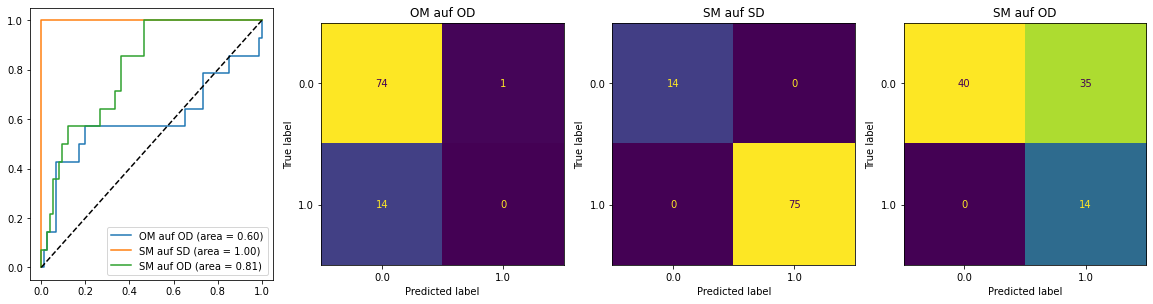

Auswertung Setup mit linearer SVC
Modell          | Accuracy   | Precision  | Recall     | F1        
OM auf OD       | 0.83       | 0.00       | 0.00       | 0.00      
SM auf SD       | 1.00       | 1.00       | 1.00       | 1.00      
SM auf OD       | 0.61       | 0.29       | 1.00       | 0.44      


0

In [33]:
# aug_kc1.generate_syn_data(len(ds_kc1_train), balance=True)
# aug_kc1.get_syn_data(combine=True)
# an_kc1_2 = daat.Analyser(aug_kc1.get_syn_data(combine=True), KC1_TARGET)

In [53]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm
from sklearn.model_selection import cross_val_score
import sklearn.metrics as skl_m

from sklearn.utils.class_weight import compute_class_weight

train_epochs = 100
n_labels = 2
callback_early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

def test_ffann_10_100(ratio):
    runs = 100
    ds_kc1_an = an_kc1.dataset
    ds_kc1_train, ds_kc1_test, ds_kc1_gen = daat_test.split_data_from_train(ds_kc1_an, KC1_TARGET,0.7,ratio)

    # Datensatz Augmentation Einstellung
    aug_kc1 = daat.Generator(ds_kc1_gen, 'defects')

    # Unabhängige Werte über Distribution
    aug_kc1.add_instruction(daat_ins('total_Op', daat.Gen_Distribution(rng_min=0)))
    aug_kc1.add_instruction(daat_ins('total_Opnd', daat.Gen_Distribution(rng_min=0)))

    # uniq sollten jeweils kleiner sein als total -> total beachten
    aug_kc1.add_instruction(daat_ins('uniq_Op', daat.Gen_NextMean(10), ['total_Op']))
    aug_kc1.add_instruction(daat_ins('uniq_Opnd', daat.Gen_NextMean(10), ['total_Opnd']))

    aug_kc1.add_instruction(daat_ins('lOCode', daat.Gen_NextMean(10, rng_min=0)))
    aug_kc1.add_instruction(daat_ins('lOComment', daat.Gen_Cluster(10, rng_min=0)))
    aug_kc1.add_instruction(daat_ins('lOBlank', daat.Gen_Cluster(10, rng_min=0)))
    aug_kc1.add_instruction(daat_ins('locCodeAndComment', daat.Gen_None()))

    # Alle berechneten Werte mit Spline
    aug_kc1.add_instruction(daat_ins('n', daat.Gen_Spline(), ['total_Op', 'total_Opnd']))
    aug_kc1.add_instruction(daat_ins('v', daat.Gen_Spline(), 'n'))
    aug_kc1.add_instruction(daat_ins('l', daat.Gen_Spline(), ['uniq_Opnd', 'n'])) # berechnet mit v' (aus uniq_Opnd)
    aug_kc1.add_instruction(daat_ins('d', daat.Gen_NextMean(5), 'l'))
    aug_kc1.add_instruction(daat_ins('i', daat.Gen_NextMean(5), ['uniq_Opnd', 'd'])) # berechnet mit 1/l' (l' = 1/d)
    aug_kc1.add_instruction(daat_ins('e', daat.Gen_Spline(), ['v', 'l'])) # berechnet mit l' und v'
    aug_kc1.add_instruction(daat_ins('t', daat.Gen_Spline(), 'e'))
    aug_kc1.add_instruction(daat_ins('b', daat.Gen_Spline(), ['n', 'v']))

    aug_kc1.add_instruction(daat_ins('loc', daat.Gen_Recombine(5, rng_min=0), 'lOCode'))
    aug_kc1.add_instruction(daat_ins('branchCount', daat.Gen_Recombine(15,rng_min=0), ['lOCode', 'lOComment', 'lOBlank', 'locCodeAndComment']))
    aug_kc1.add_instruction(daat_ins('v(g)', daat.Gen_Spline(), 'branchCount'))
    aug_kc1.add_instruction(daat_ins('ev(g)', daat.Gen_Spline(), 'branchCount'))
    aug_kc1.add_instruction(daat_ins('iv(g)', daat.Gen_Spline(), 'branchCount'))

    # Angegbene Instruktionen testen
    # aug_kc1.verify_setup(balance=True)
    
    acc = np.zeros((3, runs))
    pre = np.zeros((3, runs))
    re  = np.zeros((3, runs))
    f1  = np.zeros((3, runs))

    for i in trange(runs):
        s_aug = (len(ds_kc1_train) - len(ds_kc1_gen))
        aug_kc1.generate_syn_data(s_aug, balance=True)
        ds_aug_kc1 = aug_kc1.get_syn_data(combine=True)

        x_train_org = ds_kc1_train.drop(KC1_TARGET, axis=1).to_numpy()
        y_train_org = ds_kc1_train[KC1_TARGET].to_numpy()
        org_weights = dict(enumerate(compute_class_weight('balanced', classes=np.unique(y_train_org), y=y_train_org)))
        model_org = daat_test.create_custom_class_model(x_train_org.shape[1], n_labels, n=3, nodes=8)
        model_org.fit(x_train_org, y_train_org, epochs=train_epochs, verbose=0, class_weight=org_weights, callbacks=[callback_early])

        x_train_gen = ds_kc1_gen.drop(KC1_TARGET, axis=1).to_numpy()
        y_train_gen = ds_kc1_gen[KC1_TARGET].to_numpy()
        gen_weights = dict(enumerate(compute_class_weight('balanced', classes=np.unique(y_train_gen), y=y_train_gen)))
        model_gen = daat_test.create_custom_class_model(x_train_gen.shape[1], n_labels, n=3, nodes=8)
        model_gen.fit(x_train_gen, y_train_gen, epochs=train_epochs, verbose=0, class_weight=gen_weights, callbacks=[callback_early])

        x_train_aug = ds_aug_kc1.drop(KC1_TARGET, axis=1).to_numpy()
        y_train_aug = ds_aug_kc1[KC1_TARGET].to_numpy()
        aug_weights = dict(enumerate(compute_class_weight('balanced', classes=np.unique(y_train_aug), y=y_train_aug)))
        model_aug = daat_test.create_custom_class_model(x_train_aug.shape[1], n_labels, n=3, nodes=8)
        model_aug.fit(x_train_aug, y_train_aug, epochs=train_epochs, verbose=0, class_weight=aug_weights, callbacks=[callback_early])

        x_test = ds_kc1_test.drop(KC1_TARGET, axis=1).to_numpy()
        y_test = ds_kc1_test[KC1_TARGET].to_numpy()

        org_loss, org_acc = model_org.evaluate(x_test, y_test, verbose=0)
        org_pred = np.argmax(model_org.predict(x_test, verbose=0), axis = 1)
        acc[0,i] = skl_m.accuracy_score(y_test, org_pred)
        pre[0,i] = skl_m.precision_score(y_test, org_pred, zero_division=0)
        re [0,i] = skl_m.recall_score(y_test, org_pred, zero_division=0)
        f1 [0,i] = skl_m.f1_score(y_test, org_pred, zero_division=0)

        aug_loss, aug_acc = model_aug.evaluate(x_test, y_test, verbose=0)
        aug_pred = np.argmax(model_aug.predict(x_test, verbose=0), axis = 1)
        acc[1,i] = skl_m.accuracy_score(y_test, aug_pred)
        pre[1,i] = skl_m.precision_score(y_test, aug_pred, zero_division=0)
        re [1,i] = skl_m.recall_score(y_test, aug_pred, zero_division=0)
        f1 [1,i] = skl_m.f1_score(y_test, aug_pred, zero_division=0)

        gen_loss, gen_acc = model_gen.evaluate(x_test, y_test, verbose=0)
        gen_pred = np.argmax(model_gen.predict(x_test, verbose=0), axis = 1)
        acc[2,i] = skl_m.accuracy_score(y_test, gen_pred)
        pre[2,i] = skl_m.precision_score(y_test, gen_pred, zero_division=0)
        re [2,i] = skl_m.recall_score(y_test, gen_pred, zero_division=0)
        f1 [2,i] = skl_m.f1_score(y_test, gen_pred, zero_division=0)
        
        if i == 9 or i == 99:
            run = i+1
            print(acc[0,:run])
            print('='* 70)
            print('Evaluation', str(run), 'runs')
            print('='* 70)
            print('org_acc: %.3f' % (np.average(acc[0,:run])), '|', 'gen_acc: %.3f' % (np.average(acc[2,:run])), '|', 'syn_acc: %.3f' % (np.average(acc[1,:run])))
            print('org_pre: %.3f' % (np.average(pre[0,:run])), '|', 'gen_pre: %.3f' % (np.average(pre[2,:run])), '|', 'syn_pre: %.3f' % (np.average(pre[1,:run])))
            print('org_re:  %.3f' % (np.average(re[0,:run])) , '|', 'gen_re:  %.3f' % (np.average(re[2,:run])),  '|', 'syn_re:  %.3f' % (np.average(re[1,:run])))
            print('org_f1:  %.3f' % (np.average(f1[0,:run])) , '|', 'gen_f1:  %.3f' % (np.average(f1[2,:run])),  '|', 'syn_f1:  %.3f' % (np.average(f1[1,:run])))
            print('='* 70)


In [54]:
test_ffann_10_100(0.1)
test_ffann_10_100(0.2)
test_ffann_10_100(0.4)

complete:    2107 
train data:  1474   0.70 
test data:    633   0.30 
gen data:     148   0.07 


  0%|          | 0/100 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

[0.61295419 0.77567141 0.49763033 0.77251185 0.63349131 0.84044234
 0.60189573 0.81990521 0.59241706 0.77725118]
Evaluation 10 runs
org_acc: 0.692 | gen_acc: 0.601 | syn_acc: 0.773
org_pre: 0.278 | gen_pre: 0.239 | syn_pre: 0.359
org_re:  0.649 | gen_re:  0.748 | syn_re:  0.537
org_f1:  0.373 | gen_f1:  0.355 | syn_f1:  0.407


processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

[0.61295419 0.77567141 0.49763033 0.77251185 0.63349131 0.84044234
 0.60189573 0.81990521 0.59241706 0.77725118 0.46445498 0.5450237
 0.65718799 0.71879937 0.83096367 0.74565561 0.57503949 0.62243286
 0.65718799 0.84202212 0.51184834 0.75987362 0.65876777 0.56556082
 0.6192733  0.60347551 0.79146919 0.63981043 0.5371248  0.60347551
 0.64296998 0.84518167 0.84518167 0.61769352 0.65402844 0.75197472
 0.81832543 0.58293839 0.63981043 0.75039494 0.72985782 0.66508689
 0.69194313 0.65244866 0.76619273 0.61769352 0.76935229 0.57661927
 0.68878357 0.62559242 0.84518167 0.76935229 0.69984202 0.84518167
 0.57977883 0.81516588 0.6492891  0.63349131 0.61769352 0.65876777
 0.60347551 0.63665087 0.79936809 0.71721959 0.72669826 0.66350711
 0.53238547 0.835703   0.80410742 0.82306477 0.59873618 0.58609795
 0.69352291 0.79936809 0.78830964 0.60979463 0.65402844 0.73301738
 0.84992101 0.60031596 0.83254344 0.60821485 0.71879937 0.76619273
 0.63823065 0.61611374 0.61137441 0.58609795 0.68246445 0.72669

  0%|          | 0/100 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

[0.63981043 0.69826224 0.8436019  0.58135861 0.73933649 0.58135861
 0.62243286 0.79778831 0.77251185 0.61295419]
Evaluation 10 runs
org_acc: 0.689 | gen_acc: 0.621 | syn_acc: 0.753
org_pre: 0.310 | gen_pre: 0.224 | syn_pre: 0.274
org_re:  0.656 | gen_re:  0.598 | syn_re:  0.489
org_f1:  0.375 | gen_f1:  0.320 | syn_f1:  0.326


processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

[0.63981043 0.69826224 0.8436019  0.58135861 0.73933649 0.58135861
 0.62243286 0.79778831 0.77251185 0.61295419 0.58451817 0.74407583
 0.66034755 0.84676145 0.63981043 0.56556082 0.57187994 0.78041074
 0.70616114 0.82938389 0.81200632 0.83728278 0.64296998 0.78672986
 0.54976303 0.81990521 0.82464455 0.7014218  0.84518167 0.68562401
 0.83254344 0.62085308 0.78988942 0.77409163 0.72037915 0.60979463
 0.60189573 0.71721959 0.60663507 0.81200632 0.53080569 0.79620853
 0.80884676 0.56240126 0.6793049  0.60031596 0.76619273 0.52922591
 0.59083728 0.78830964 0.67772512 0.73301738 0.62559242 0.77093207
 0.57819905 0.60347551 0.61769352 0.84518167 0.73459716 0.64139021
 0.49605055 0.82306477 0.47077409 0.7614534  0.78988942 0.79146919
 0.66508689 0.55450237 0.54028436 0.7314376  0.67772512 0.60031596
 0.82148499 0.57503949 0.8436019  0.63191153 0.58135861 0.72511848
 0.64454976 0.63191153 0.53396524 0.63191153 0.74881517 0.66192733
 0.76619273 0.80884676 0.6271722  0.51816746 0.71248025 0.8183

  0%|          | 0/100 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

[0.65244866 0.69194313 0.68720379 0.82464455 0.78041074 0.84676145
 0.66508689 0.66982622 0.5892575  0.69668246]
Evaluation 10 runs
org_acc: 0.710 | gen_acc: 0.664 | syn_acc: 0.734
org_pre: 0.287 | gen_pre: 0.254 | syn_pre: 0.289
org_re:  0.584 | gen_re:  0.645 | syn_re:  0.602
org_f1:  0.341 | gen_f1:  0.326 | syn_f1:  0.385


processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

generating features:   0%|          | 0/21 [00:00<?, ?it/s]

[0.65244866 0.69194313 0.68720379 0.82464455 0.78041074 0.84676145
 0.66508689 0.66982622 0.5892575  0.69668246 0.56398104 0.8436019
 0.75829384 0.84518167 0.61295419 0.50236967 0.79462875 0.671406
 0.61295419 0.73617694 0.59557662 0.51974724 0.72985782 0.5971564
 0.61453397 0.54976303 0.835703   0.7235387  0.66982622 0.84518167
 0.72827804 0.49605055 0.73617694 0.81516588 0.6271722  0.66824645
 0.72195893 0.66034755 0.67614534 0.84518167 0.81832543 0.60031596
 0.84202212 0.78199052 0.65718799 0.61769352 0.84676145 0.54818325
 0.81516588 0.78830964 0.60347551 0.81674566 0.57977883 0.58135861
 0.69510269 0.7235387  0.835703   0.77093207 0.69984202 0.5892575
 0.84044234 0.84518167 0.69036335 0.69036335 0.5971564  0.61137441
 0.62559242 0.79778831 0.8056872  0.81042654 0.77725118 0.81042654
 0.6192733  0.71563981 0.84518167 0.60821485 0.52132701 0.8056872
 0.81042654 0.53554502 0.64296998 0.5150079  0.84518167 0.69036335
 0.59557662 0.62401264 0.64770932 0.77251185 0.76619273 0.77567141
 

# Test 2: Pima Indians Diabetes Database

processing features:   0%|          | 0/9 [00:00<?, ?it/s]

Datensatz Übersicht
Feature Anzahl:           9
Anazhl Einträge:        393
leere Einträge:           0
----------------------------------------------------------------------------------------------------------------
kleinstes Feature : class      | Anzahl 2          | ML Art: Klassifikation
größtes Feature   : dpf        | Anzahl 331        | ML Art: Regression

Feature Übersicht
----------------------------------------------------------------------------------------------------------------
Feature              | Type       | Gesamt     | Einzel     | NaNs       || min        | 50%        | max        
----------------------------------------------------------------------------------------------------------------
n_preg               | int64      |        393 |         17 |          0 ||       0.00 |       2.00 |      17.00 
plasma_con           | int64      |        393 |        118 |          0 ||       0.00 |     119.00 |     198.00 
blood_mm             | int64      |        393 |

plotting data:   0%|          | 0/9 [00:00<?, ?it/s]

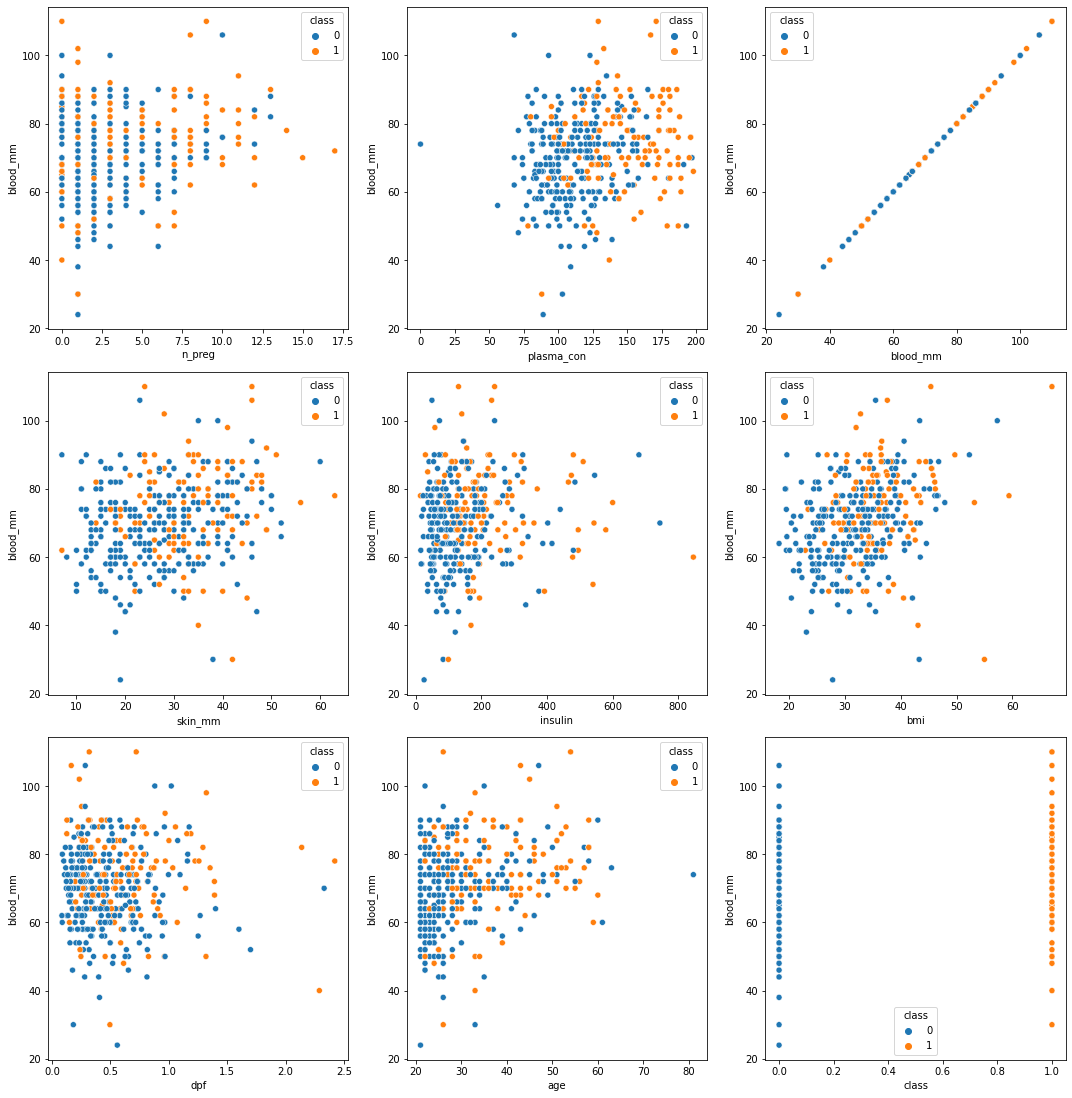

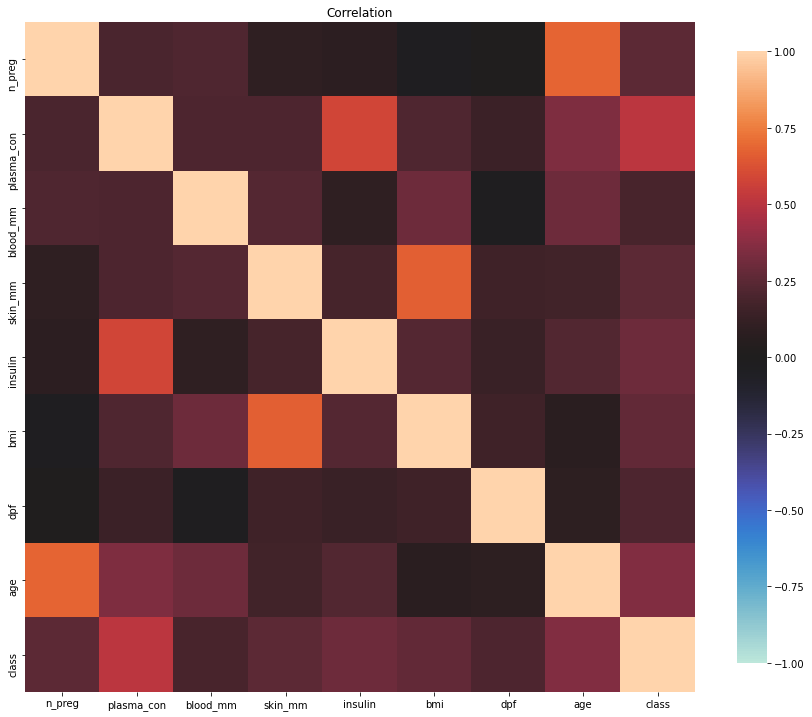

In [8]:
# globale Einstellungen
path_ds_diabetes = "./data/diabetes_pima.csv"
ds_diabetes = pd.read_csv(path_ds_diabetes, header=None)

ds_diabetes.columns = ['n_preg', 'plasma_con', 'blood_mm', 'skin_mm', 'insulin', 'bmi', 'dpf', 'age', 'class']
ds_diabetes = ds_diabetes.drop(ds_diabetes[ds_diabetes.age == 0.0].index)
ds_diabetes = ds_diabetes.drop(ds_diabetes[ds_diabetes.blood_mm == 0.0].index)
ds_diabetes = ds_diabetes.drop(ds_diabetes[ds_diabetes.skin_mm == 0.0].index)
ds_diabetes = ds_diabetes.drop(ds_diabetes[ds_diabetes.insulin == 0.0].index)
ds_diabetes = ds_diabetes.drop(ds_diabetes[ds_diabetes.bmi == 0.0].index)

an_diabetes = daat.Analyser(ds_diabetes, 'class')
an_diabetes.show_dataset_info()
# an_diabetes.plot_features(y_feature='blood_mm', color=True)
# an_diabetes.plot_correlation()

In [9]:
def advanced_performance_measures(predicted, truth):
    tp = tn = fp = fn = 0

    for i in range(0, len(predicted)):
        if (predicted[i] == 1 and truth[i] == 1): tp += 1
        elif (predicted[i] == 0 and truth[i] == 0): tn += 1
        elif (predicted[i] == 1 and truth[i] == 0): fp += 1
        elif (predicted[i] == 0 and truth[i] == 1): fn += 1

    total = tp + tn + fp + fn
    acc = (tp + tn) / (total)

    pos = tp + fp
    tru = tp + fn

    pre = 0 if pos == 0 else (tp) / (tp + fp)
    rec = 0 if tru == 0 else (tp) / (tp + fn)

    f_s = pre + rec

    f1 = 0 if f_s == 0 else 2 * ((pre * rec) / (f_s))

    return [acc, pre, rec, f1]


# specific test for diabetes dataset.
def run_test_class_ratio(data, target, ratio, cycles, balance = False):
    randomlist = random.sample(range(0, 400), cycles)
    n_samples = len(data)
    metrics = np.zeros((cycles, 9, 4))
    
    for c in trange(cycles, desc='running cycle', leave=False):
    
        # Generator Seed Daten nach ratio bestimmen
        data_x = data.drop(target, axis = 1).to_numpy()
        data_y = data[target].to_numpy()

        x_gen, _, y_gen, _ = train_test_split(data_x, data_y, train_size=ratio, 
                                              random_state=randomlist[c], stratify=data_y)
        y_gen = y_gen.reshape(len(y_gen), 1)
        ds_gen_ratio = pd.DataFrame(np.append(x_gen, y_gen, axis = 1), columns=data.columns)

        # Generator Objekte erstellen
        gen_ratio = daat.Generator(ds_gen_ratio, "class")
        gen_100 = daat.Generator(data, "class")

        # Instruktionen hinzufügen
        gen_ratio.add_instruction(daat_ins("age", daat.Gen_Distribution(rng_min=21)))
        gen_ratio.add_instruction(daat_ins("n_preg", daat.Gen_Distribution(rng_min=0)))
        gen_ratio.add_instruction(daat_ins("blood_mm", daat.Gen_Recombine(15, rng_min=0), ['age']))
        gen_ratio.add_instruction(daat_ins("skin_mm", daat.Gen_Cluster(10, rng_min=0), ['n_preg', 'age']))
        gen_ratio.add_instruction(daat_ins("insulin", daat.Gen_NextMean(5, rng_min=0), ['skin_mm', 'blood_mm']))
        gen_ratio.add_instruction(daat_ins("plasma_con", daat.Gen_NextMean(10, rng_min=0), ['age','insulin']))
        gen_ratio.add_instruction(daat_ins("bmi", daat.Gen_Recombine(5, rng_min=0), ['insulin', 'skin_mm', 'age']))
        gen_ratio.add_instruction(daat_ins("dpf", daat.Gen_NextMean(5, rng_min=0), ['age', 'n_preg']))

        gen_100.add_instruction(daat_ins("age", daat.Gen_Distribution(rng_min=21)))
        gen_100.add_instruction(daat_ins("n_preg", daat.Gen_Distribution(rng_min=0)))
        gen_100.add_instruction(daat_ins("blood_mm", daat.Gen_Recombine(15, rng_min=0), ['age']))
        gen_100.add_instruction(daat_ins("skin_mm", daat.Gen_Cluster(10, rng_min=0), ['n_preg', 'age']))
        gen_100.add_instruction(daat_ins("insulin", daat.Gen_NextMean(5, rng_min=0), ['skin_mm', 'blood_mm']))
        gen_100.add_instruction(daat_ins("plasma_con", daat.Gen_NextMean(10, rng_min=0), ['age','insulin']))
        gen_100.add_instruction(daat_ins("bmi", daat.Gen_Recombine(5, rng_min=0), ['insulin', 'skin_mm', 'age']))
        gen_100.add_instruction(daat_ins("dpf", daat.Gen_NextMean(5, rng_min=0), ['age', 'n_preg']))

        # Daten generieren
        gen_ratio.generate_syn_data(n_samples, balance=balance)
        ds_data_syn_ratio = gen_ratio.get_syn_data()
        gen_100.generate_syn_data(n_samples, balance=balance)
        ds_data_syn_100 = gen_100.get_syn_data()
        

        # original Daten
        org_x = data.drop(target, axis = 1).to_numpy()
        org_y = data[target].to_numpy()
        org_x_train, org_x_test, org_y_train, org_y_test = train_test_split(
            org_x, org_y, train_size = 0.7, random_state = 42, stratify = org_y)
        
        # syn_ratio
        syn_ratio_x = ds_data_syn_ratio.drop(target, axis = 1).to_numpy()
        syn_ratio_y = ds_data_syn_ratio[target].to_numpy()
        syn_ratio_x_train, syn_ratio_x_test, syn_ratio_y_train, syn_ratio_y_test = train_test_split(
            syn_ratio_x, syn_ratio_y, train_size = 0.7, random_state = 42, stratify = syn_ratio_y)
        
        #syn_100
        syn_100_x = ds_data_syn_100.drop(target, axis = 1).to_numpy()
        syn_100_y = ds_data_syn_100[target].to_numpy()
        syn_100_x_train, syn_100_x_test, syn_100_y_train, syn_100_y_test = train_test_split(
            syn_100_x, syn_100_y, train_size = 0.7, random_state = 42, stratify = syn_100_y)
        
        # Erstellen der drei Test-SVMs
        svm_org = make_pipeline(skl_prep.StandardScaler(), skl_svm.SVC(cache_size = 200, max_iter = 10000))
        svm_org.fit(org_x_train, org_y_train)
        
        svm_syn_ratio = make_pipeline(skl_prep.StandardScaler(), skl_svm.SVC(cache_size = 200, max_iter = 10000))
        svm_syn_ratio.fit(syn_ratio_x_train, syn_ratio_y_train)
        
        svm_syn_100 = make_pipeline(skl_prep.StandardScaler(), skl_svm.SVC(cache_size = 200, max_iter = 10000))
        svm_syn_100.fit(syn_100_x_train, syn_100_y_train)
        
        pred_org_o     = svm_org.predict(org_x_test)
        pred_org_srat  = svm_org.predict(syn_ratio_x_test)
        pred_org_s100  = svm_org.predict(syn_100_x_test)
        
        pred_srat_o    = svm_syn_ratio.predict(org_x_test)
        pred_srat_srat = svm_syn_ratio.predict(syn_ratio_x_test)
        pred_srat_s100 = svm_syn_ratio.predict(syn_100_x_test)
        
        pred_s100_o    = svm_syn_100.predict(org_x_test)
        pred_s100_srat = svm_syn_100.predict(syn_ratio_x_test)
        pred_s100_s100 = svm_syn_100.predict(syn_100_x_test)
         
        metrics[c,0] = advanced_performance_measures(pred_org_o, org_y_test)
        metrics[c,1] = advanced_performance_measures(pred_org_srat, syn_ratio_y_test)
        metrics[c,2] = advanced_performance_measures(pred_org_s100, syn_100_y_test)
        
        metrics[c,3] = advanced_performance_measures(pred_srat_o, org_y_test)
        metrics[c,4] = advanced_performance_measures(pred_srat_srat, syn_ratio_y_test)
        metrics[c,5] = advanced_performance_measures(pred_srat_s100, syn_100_y_test)
        
        metrics[c,6] = advanced_performance_measures(pred_s100_o, org_y_test)
        metrics[c,7] = advanced_performance_measures(pred_s100_srat, syn_ratio_y_test)
        metrics[c,8] = advanced_performance_measures(pred_s100_s100, syn_100_y_test)
        
    # TABELLE
    tab_head_1 = '| {:10} || {:30} || {:30} || {:30} |'
    tab_head_2 = '| {:10} || {:8} | {:8} | {:8} || {:8} | {:8} | {:8} || {:8} | {:8} | {:8} |'
    tab_col = ['Metric', 'Accuracy', 'Precision', 'Recall', 'F1']
    tab_head_col = ['Modell', '            OG', '           Syn 10', '          Syn 100']
    header_syn = 'Syn ' + str(100*ratio) 
    tab_head_col_2 = ['Data Set', 'OG 30', header_syn, 'Syn 100', 'OG 30', header_syn, 'Syn 100', 'OG 30', header_syn, 'Syn 100']
    tab_line_1 = '| {:10} || {:8.3f} | {:8.3f} | {:8.3f} || {:8.3f} | {:8.3f} | {:8.3f} || {:8.3f} | {:8.3f} | {:8.3f} |'
    
    line_len = 9*10 + 14 + 12
    print('=' * line_len)
    print('Data Set Evaluation for', cycles, 'Cycles, ', ratio, 'Seed Data')
    print('-' * line_len)
    print(tab_head_1.format(*tab_head_col))
    print(tab_head_2.format(*tab_head_col_2))
    print('-' * line_len)

    for i in range(0, len(metrics[0,0])):
        print(tab_line_1.format(tab_col[i+1], 
                                (np.sum(metrics[:,0,i])/cycles), (np.sum(metrics[:,1,i])/cycles), (np.sum(metrics[:,2,i])/cycles), 
                                (np.sum(metrics[:,3,i])/cycles), (np.sum(metrics[:,4,i])/cycles), (np.sum(metrics[:,5,i])/cycles), 
                                (np.sum(metrics[:,6,i])/cycles), (np.sum(metrics[:,7,i])/cycles), (np.sum(metrics[:,8,i])/cycles)
             ))

    print('=' * line_len)

In [10]:
run_test_class_ratio(ds_diabetes, 'class', 0.1, 10, balance=True)
run_test_class_ratio(ds_diabetes, 'class', 0.2, 10, balance=True)
run_test_class_ratio(ds_diabetes, 'class', 0.4, 10, balance=True)
run_test_class_ratio(ds_diabetes, 'class', 0.6, 10, balance=True)
run_test_class_ratio(ds_diabetes, 'class', 0.8, 10, balance=True)

running cycle:   0%|          | 0/10 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

Data Set Evaluation for 10 Cycles,  0.1 Seed Data
--------------------------------------------------------------------------------------------------------------------
| Modell     ||             OG                 ||            Syn 10              ||           Syn 100              |
| Data Set   || OG 30    | Syn 10.0 | Syn 100  || OG 30    | Syn 10.0 | Syn 100  || OG 30    | Syn 10.0 | Syn 100  |
--------------------------------------------------------------------------------------------------------------------
| Accuracy   ||    0.780 |    0.846 |    0.718 ||    0.713 |    0.999 |    0.858 ||    0.644 |    0.885 |    0.983 |
| Precision  ||    0.686 |    0.967 |    1.000 ||    0.569 |    0.998 |    0.969 ||    0.479 |    0.826 |    0.978 |
| Recall     ||    0.615 |    0.730 |    0.578 ||    0.623 |    1.000 |    0.818 ||    0.867 |    0.992 |    0.997 |
| F1         ||    0.649 |    0.817 |    0.732 ||    0.584 |    0.999 |    0.874 ||    0.617 |    0.900 |    0.988 |


running cycle:   0%|          | 0/10 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

Data Set Evaluation for 10 Cycles,  0.2 Seed Data
--------------------------------------------------------------------------------------------------------------------
| Modell     ||             OG                 ||            Syn 10              ||           Syn 100              |
| Data Set   || OG 30    | Syn 20.0 | Syn 100  || OG 30    | Syn 20.0 | Syn 100  || OG 30    | Syn 20.0 | Syn 100  |
--------------------------------------------------------------------------------------------------------------------
| Accuracy   ||    0.780 |    0.819 |    0.715 ||    0.679 |    0.984 |    0.915 ||    0.631 |    0.950 |    0.974 |
| Precision  ||    0.686 |    0.998 |    0.996 ||    0.512 |    0.980 |    0.938 ||    0.470 |    0.937 |    0.975 |
| Recall     ||    0.615 |    0.660 |    0.577 ||    0.764 |    0.990 |    0.937 ||    0.885 |    0.973 |    0.986 |
| F1         ||    0.649 |    0.788 |    0.728 ||    0.612 |    0.985 |    0.935 ||    0.614 |    0.953 |    0.980 |


running cycle:   0%|          | 0/10 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

Data Set Evaluation for 10 Cycles,  0.4 Seed Data
--------------------------------------------------------------------------------------------------------------------
| Modell     ||             OG                 ||            Syn 10              ||           Syn 100              |
| Data Set   || OG 30    | Syn 40.0 | Syn 100  || OG 30    | Syn 40.0 | Syn 100  || OG 30    | Syn 40.0 | Syn 100  |
--------------------------------------------------------------------------------------------------------------------
| Accuracy   ||    0.780 |    0.764 |    0.718 ||    0.675 |    0.993 |    0.967 ||    0.638 |    0.969 |    0.979 |
| Precision  ||    0.686 |    0.996 |    0.996 ||    0.507 |    0.990 |    0.973 ||    0.475 |    0.954 |    0.977 |
| Recall     ||    0.615 |    0.587 |    0.581 ||    0.777 |    0.999 |    0.978 ||    0.862 |    0.996 |    0.992 |
| F1         ||    0.649 |    0.730 |    0.733 ||    0.613 |    0.994 |    0.976 ||    0.612 |    0.974 |    0.984 |


running cycle:   0%|          | 0/10 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

Data Set Evaluation for 10 Cycles,  0.6 Seed Data
--------------------------------------------------------------------------------------------------------------------
| Modell     ||             OG                 ||            Syn 10              ||           Syn 100              |
| Data Set   || OG 30    | Syn 60.0 | Syn 100  || OG 30    | Syn 60.0 | Syn 100  || OG 30    | Syn 60.0 | Syn 100  |
--------------------------------------------------------------------------------------------------------------------
| Accuracy   ||    0.780 |    0.742 |    0.724 ||    0.669 |    0.981 |    0.976 ||    0.628 |    0.956 |    0.984 |
| Precision  ||    0.686 |    0.989 |    0.996 ||    0.504 |    0.973 |    0.983 ||    0.467 |    0.938 |    0.978 |
| Recall     ||    0.615 |    0.579 |    0.590 ||    0.803 |    0.996 |    0.982 ||    0.867 |    0.994 |    0.999 |
| F1         ||    0.649 |    0.725 |    0.739 ||    0.617 |    0.984 |    0.982 ||    0.606 |    0.965 |    0.988 |


running cycle:   0%|          | 0/10 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

processing classes:   0%|          | 0/2 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

generating features:   0%|          | 0/8 [00:00<?, ?it/s]

Data Set Evaluation for 10 Cycles,  0.8 Seed Data
--------------------------------------------------------------------------------------------------------------------
| Modell     ||             OG                 ||            Syn 10              ||           Syn 100              |
| Data Set   || OG 30    | Syn 80.0 | Syn 100  || OG 30    | Syn 80.0 | Syn 100  || OG 30    | Syn 80.0 | Syn 100  |
--------------------------------------------------------------------------------------------------------------------
| Accuracy   ||    0.780 |    0.749 |    0.724 ||    0.642 |    0.985 |    0.976 ||    0.653 |    0.977 |    0.979 |
| Precision  ||    0.686 |    0.994 |    0.994 ||    0.480 |    0.983 |    0.975 ||    0.488 |    0.971 |    0.976 |
| Recall     ||    0.615 |    0.611 |    0.591 ||    0.867 |    0.993 |    0.990 ||    0.856 |    0.995 |    0.994 |
| F1         ||    0.649 |    0.755 |    0.740 ||    0.616 |    0.988 |    0.982 ||    0.621 |    0.983 |    0.984 |
